In [1]:
import pandas as pd
import scipy.io
import h5py
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats
import antropy as ant
filepath = '/Users/yutingzhang/Downloads/subInfo_316_attention_210226.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

<ipython-input-1-32c4c0667fd3>:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(filepath)


***THIS IS THE MULTIVARIATE METHOD***

In [38]:
#split the mat_rest and label into training and testing groups
mat_rest = arrays['mat_rest']
subList = arrays['subList']
X = mat_rest
Y = subList[1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [39]:
#standardize the data, fit on the training data and apply the fit to both training and testing datasets. 
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
#initiate PCA model
#either pick the variance to be used
pca_var = PCA(0.2) # usually use 5 components to retain 20% variance
#or pick the number of componenets to be used
pca_com = PCA(n_components=3)

In [50]:
#fit the data using pca_var
pca_var.fit(X_train)
#look for how many components are retained to achieve 95% variance
pca_var.n_components_
#apply the transform to both 
X_train = pca_var.transform(X_train)
X_test = pca_var.transform(X_test)
#35778

In [65]:
ran = round(len(mat_rest[0])/1000)
n_sub = len(mat_rest)
sub_result = []
for i in range(n_sub):
    sub_data = mat_rest[i]
    for j in range(ran):
        sphere_prior = j*1000
        if j != ran-1:
            sphere_posterior = (j+1)*1000
        else:
            sphere_posterior = len(mat_rest[0])-1
        for k in range(ran):
            seed_prior = k*1000
            if k != ran-1:
                seed_posterior = (k+1)*1000
            else:
                seed_posterior = len(mat_rest[0])-1
            X = sub_data[sphere_prior:sphere_posterior]
            Y = sub_data[seed_prior:seed_posterior]
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
            pca_com = PCA(n_components=3)
            #fit the data using pca_var
            pca_var.fit(X_train)
            #look for how many components are retained to achieve 95% variance
            pca_var.n_components_
            #apply the transform to both 
            X_train = pca_var.transform(X_train)
            X_test = pca_var.transform(X_test)
            logisticRegr = LogisticRegression(solver = 'lbfgs')
            logisticRegr.fit(X_train,Y_train)
            score = logisticRegr.score(X_test,Y_test)
            sub_result.append(score)

36

****CPM METHOD STARTS FROM HERE!!!****

**construct connectivity matrix and select the edge**

*1. read in data, a matrix of 268*268 for each subject*

In [2]:
def read_file(path):
    filepath = path
    arrays_conmat = {}
    f = h5py.File(filepath)
    
    for k, v in f.items():
        arrays_conmat[k] = np.array(v)
        
    return arrays_conmat

*2. Extract the relevant data into numpy array*

In [3]:
def extract_data(arrays_conmat):
    ##extract the phenotype data
    pheno = arrays_conmat['subList'][1]
    ##calculate the mean of the resting data
    matrix = arrays_conmat['conMatRun268']
    rest = matrix[0:4] #first four columns are resting state. 
    shape = np.shape(matrix)
    new = []
    
    for sub in range(shape[1]):
        sub_data = rest[:,sub,:,:]
        sub_mean = np.mean(sub_data,axis=0) #Take the average between the four runs. 
        new.append(sub_mean) #the size of new is (316,268,268)
        
    return pheno, new

*Now, we have pheno, which is the pheno data (size:316, one for each subject), and new, which is the matrix (size: (316,268,268), one matrix for each of 316 subject)*

*3. Calculate the correlation matrix and p-value matrix*

In [4]:
def matrix_gen(pheno,new):
    new_new = np.asarray(new)
    cor_matrix = []
    p_matrix = []
    
    for i in range(268):
        for j in range(268):
            data = new_new[:,i,j]
            cor = stats.pearsonr(data,pheno)
            cor_matrix.append(cor[0])
            p_matrix.append(cor[1])
            
    cor_matrix = np.asarray(cor_matrix)
    p_matrix = np.asarray(p_matrix)
    
    cor_matrix_resize = np.resize(cor_matrix,(268,268))
    cor_matrix_resize = np.nan_to_num(cor_matrix_resize)
    
    p_matrix_resize = np.resize(p_matrix,(268,268))
    p_matrix_resize = np.nan_to_num(p_matrix_resize)
    
    return cor_matrix_resize,p_matrix_resize

*4. With the correlation matrix and p-value matrix, we need to select positive and negative edges. If specific edge is greater than 0 and have p-value less than 0.05, it will be marked with 1, otherwise 0, in the pos_matrix. Likewise, if specific edge is less than 0 and have p-value less than 0.05, it will be marked with 1, otherwise 0, in the neg_matrix.*

In [5]:
def edge_selection(cor_matrix_resize,p_matrix_resize,target_size):
    
    #create positive edge matrix and negative edge matrix
    pos_matrix = []
    neg_matrix = []
    
    assert np.shape(cor_matrix_resize) == target_size, "Wrong size!"
    assert np.shape(p_matrix_resize) == target_size, "Wrong size!"
    
    for i in range(np.shape(cor_matrix_resize)[0]):
        for j in range(np.shape(cor_matrix_resize)[0]):
            cor = cor_matrix_resize[i,j]
            p = p_matrix_resize[i,j]
            if cor>0 and p<0.05:
                pos_matrix.append(1)
                neg_matrix.append(0)
            elif cor<0 and p<0.05: 
                pos_matrix.append(0)
                neg_matrix.append(1)
            else:
                pos_matrix.append(0)
                neg_matrix.append(0)
                
    pos_matrix = np.reshape(pos_matrix,target_size)
    neg_matrix = np.reshape(neg_matrix,target_size)
    
    return pos_matrix,neg_matrix

*5. Now, we have two matrices, pos_mat and neg_mat, composed of 1 and 0. We will do an elementwise multiplication to select the positive edge and negative edge on the matrix*

In [6]:
def element_multiply(all_sub_data,pos_matrix,neg_matrix):
    all_pos = []
    all_neg = []
    for sub in all_sub_data:
        sub_data_pos = np.multiply(sub,pos_matrix)
        sub_data_neg = np.multiply(sub,neg_matrix)
        sub_data_pos = np.reshape(sub_data_pos,(268,268))
        sub_data_neg = np.reshape(sub_data_neg,(268,268))
        all_pos.append(sub_data_pos)
        all_neg.append(sub_data_neg)
    return all_pos,all_neg

*6. Now we have the matrix of positive edge and matrix of negative edge. We want to calculate the summary statistics. Therefore, for each subject, there will be two numbers, with one corresponding to positive edges' summary stats and the other corresponding to negative edges' summary stats.*

In [213]:
def summary_stats(all_pos,all_neg):
    pos_sum = []
    neg_sum = []
    for pos_mat in all_pos:
        pos = np.sum(pos_mat)
        pos_sum.append(pos)
    for neg_mat in all_neg:
        neg = np.sum(neg_mat)
        neg_sum.append(neg)
    return pos_sum, neg_sum

In [214]:
def main():
    size = (268,268) #set up the size of each matrix for each subject
    filepath = '/Users/yutingzhang/Downloads/conmat_HCP_run_316_201216.mat'
    print('finished with filepath')
    array = read_file(filepath) #read in the file
    pheno, sub_mat = extract_data(array) #extract the matrix and phenotype data
    print('finished with a')
    cor_mat, p_mat = matrix_gen(pheno,sub_mat) #extract the correlation matrix and p-value matrix for all subjects
    pos_mat, neg_mat = edge_selection(cor_mat,p_mat,size) #edge selection with two matrices, one for pos, one for neg
    print('finished with b')
    sub_pos, sub_neg = element_multiply(sub_mat,pos_mat,neg_mat) #using the matrix to apply to the actual subject data to select that
    sub_sum_pos,sub_sum_neg = summary_stats(sub_pos,sub_neg) #calculate the summary statistics
    print('finished with c')
    return sub_sum_pos,sub_sum_neg,pheno

****Implementation****

Note: Try leave-one-out ordinary least square regression, ridge regression, lasso regression, Elastic-Net, LARS-lasso, stochastic gradient descent

In [217]:
sub_sum_pos,sub_sum_neg,pheno = main()

finished with filepath


<ipython-input-2-d8281cbeaf95>:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(filepath)


finished with a
finished with b
finished with c


In [219]:
np.shape(sub_sum_neg)

(316,)

1. Ordinary least sqaure regression

In [73]:
from sklearn.linear_model import LinearRegression
def OLS(sub_sum_pos,sub_sum_neg,pheno):
    original = []
    predict = []
    
    for i in range(np.shape(sub_sum_pos)[0]):
        print("On subject %s" %i)
        loo_sub_sum_pos = np.delete(sub_sum_pos,[i])
        single_sub_sum_pos = sub_sum_pos[i]
        loo_sub_sum_neg = np.delete(sub_sum_neg,[i])
        single_sub_sum_neg = sub_sum_neg[i]
        loo_pheno = np.delete(pheno,[i])
        single_sub_pheno = pheno[i]
        X_train = np.vstack((np.reshape(loo_sub_sum_pos,(1,315)), np.reshape(loo_sub_sum_neg,(1,315))))
        X_train = np.transpose(X_train)
        Y_train = loo_pheno
        reg = LinearRegression().fit(X_train, Y_train)
        prediction = reg.predict(np.transpose(np.vstack((single_sub_sum_pos,single_sub_sum_neg))))
        original.append(single_sub_pheno)
        predict.append(prediction[0])
    return original,predict

Evaluate the result using correlation

In [74]:
original, predict = OLS(sub_sum_pos,sub_sum_neg,pheno)
cor = np.corrcoef(np.asarray(original),np.asarray(predict))[0][1]
print("Correlation of the predicted and original score is %s." %cor)

On subject 0
On subject 1
On subject 2
On subject 3
On subject 4
On subject 5
On subject 6
On subject 7
On subject 8
On subject 9
On subject 10
On subject 11
On subject 12
On subject 13
On subject 14
On subject 15
On subject 16
On subject 17
On subject 18
On subject 19
On subject 20
On subject 21
On subject 22
On subject 23
On subject 24
On subject 25
On subject 26
On subject 27
On subject 28
On subject 29
On subject 30
On subject 31
On subject 32
On subject 33
On subject 34
On subject 35
On subject 36
On subject 37
On subject 38
On subject 39
On subject 40
On subject 41
On subject 42
On subject 43
On subject 44
On subject 45
On subject 46
On subject 47
On subject 48
On subject 49
On subject 50
On subject 51
On subject 52
On subject 53
On subject 54
On subject 55
On subject 56
On subject 57
On subject 58
On subject 59
On subject 60
On subject 61
On subject 62
On subject 63
On subject 64
On subject 65
On subject 66
On subject 67
On subject 68
On subject 69
On subject 70
On subject 71
On

2. Ridge regression

In [71]:
from sklearn.linear_model import Ridge
def ridgeRegression(sub_sum_pos,sub_sum_neg,pheno):
    original = []
    predict = []

    for i in range(np.shape(sub_sum_pos)[0]):
        print("On subject %s" %i)
        loo_sub_sum_pos = np.delete(sub_sum_pos,[i])
        single_sub_sum_pos = sub_sum_pos[i]
        loo_sub_sum_neg = np.delete(sub_sum_neg,[i])
        single_sub_sum_neg = sub_sum_neg[i]
        loo_pheno = np.delete(pheno,[i])
        single_sub_pheno = pheno[i]
        X_train = np.vstack((np.reshape(loo_sub_sum_pos,(1,315)), np.reshape(loo_sub_sum_neg,(1,315))))
        X_train = np.transpose(X_train)
        Y_train = loo_pheno
        reg = Ridge(alpha = 0.0).fit(X_train, Y_train)
        prediction = reg.predict(np.transpose(np.vstack((single_sub_sum_pos,single_sub_sum_neg))))
        original.append(single_sub_pheno)
        predict.append(prediction[0])
    return original,predict

In [72]:
original, predict = ridgeRegression(sub_sum_pos,sub_sum_neg,pheno)
cor = np.corrcoef(np.asarray(original),np.asarray(predict))[0][1]
print("Correlation of the predicted and original score is %s." %cor)

On subject 0
On subject 1
On subject 2
On subject 3
On subject 4
On subject 5
On subject 6
On subject 7
On subject 8
On subject 9
On subject 10
On subject 11
On subject 12
On subject 13
On subject 14
On subject 15
On subject 16
On subject 17
On subject 18
On subject 19
On subject 20
On subject 21
On subject 22
On subject 23
On subject 24
On subject 25
On subject 26
On subject 27
On subject 28
On subject 29
On subject 30
On subject 31
On subject 32
On subject 33
On subject 34
On subject 35
On subject 36
On subject 37
On subject 38
On subject 39
On subject 40
On subject 41
On subject 42
On subject 43
On subject 44
On subject 45
On subject 46
On subject 47
On subject 48
On subject 49
On subject 50
On subject 51
On subject 52
On subject 53
On subject 54
On subject 55
On subject 56
On subject 57
On subject 58
On subject 59
On subject 60
On subject 61
On subject 62
On subject 63
On subject 64
On subject 65
On subject 66
On subject 67
On subject 68
On subject 69
On subject 70
On subject 71
On

3. Lasso regression

In [95]:
from sklearn.linear_model import Lasso
def lassoRegression(sub_sum_pos,sub_sum_neg,pheno):
    
    test_image = []
    original = []
    predict = []
    
    for i in range(np.shape(sub_sum_pos)[0]):
        print("On subject %s" %i)
        loo_sub_sum_pos = np.delete(sub_sum_pos,[i])
        single_sub_sum_pos = sub_sum_pos[i]
        loo_sub_sum_neg = np.delete(sub_sum_neg,[i])
        single_sub_sum_neg = sub_sum_neg[i]
        loo_pheno = np.delete(pheno,[i])
        single_sub_pheno = pheno[i]
        X_train = np.vstack((np.reshape(loo_sub_sum_pos,(1,315)), np.reshape(loo_sub_sum_neg,(1,315))))
        X_train = np.transpose(X_train)
        Y_train = loo_pheno
        reg = Lasso(alpha = 1.0).fit(X_train, Y_train)
        test_x = np.transpose(np.vstack((single_sub_sum_pos,single_sub_sum_neg)))
        prediction = reg.predict(test_x)
        test_image.append(test_x)
        original.append(single_sub_pheno)
        predict.append(prediction[0])
    
    return original,predict,test_image

In [96]:
original, predict, test_image = lassoRegression(sub_sum_pos,sub_sum_neg,pheno)
cor = np.corrcoef(np.asarray(original),np.asarray(predict))[0][1]
print("Correlation of the predicted and original score is %s." %cor)

On subject 0
On subject 1
On subject 2
On subject 3
On subject 4
On subject 5
On subject 6
On subject 7
On subject 8
On subject 9
On subject 10
On subject 11
On subject 12
On subject 13
On subject 14
On subject 15
On subject 16
On subject 17
On subject 18
On subject 19
On subject 20
On subject 21
On subject 22
On subject 23
On subject 24
On subject 25
On subject 26
On subject 27
On subject 28
On subject 29
On subject 30
On subject 31
On subject 32
On subject 33
On subject 34
On subject 35
On subject 36
On subject 37
On subject 38
On subject 39
On subject 40
On subject 41
On subject 42
On subject 43
On subject 44
On subject 45
On subject 46
On subject 47
On subject 48
On subject 49
On subject 50
On subject 51
On subject 52
On subject 53
On subject 54
On subject 55
On subject 56
On subject 57
On subject 58
On subject 59
On subject 60
On subject 61
On subject 62
On subject 63
On subject 64
On subject 65
On subject 66
On subject 67
On subject 68
On subject 69
On subject 70
On subject 71
On

4. Elastic-Net

In [215]:
from sklearn.linear_model import ElasticNet
def elasticNet(sub_sum_pos,sub_sum_neg,pheno):
    
    test_image = []
    original = []
    predict = []
    
    for i in range(np.shape(sub_sum_pos)[0]):
        print("On subject %s" %i)
        loo_sub_sum_pos = np.delete(sub_sum_pos,[i])
        single_sub_sum_pos = sub_sum_pos[i]
        loo_sub_sum_neg = np.delete(sub_sum_neg,[i])
        single_sub_sum_neg = sub_sum_neg[i]
        loo_pheno = np.delete(pheno,[i])
        single_sub_pheno = pheno[i]
        print(np.shape(loo_sub_sum_pos))
        X_train = np.vstack((np.reshape(loo_sub_sum_pos,(1,315)), np.reshape(loo_sub_sum_neg,(1,315))))
        X_train = np.transpose(X_train)
        Y_train = loo_pheno
        reg = ElasticNet(alpha = 1.0).fit(X_train, Y_train)
        test_x = np.transpose(np.vstack((single_sub_sum_pos,single_sub_sum_neg)))
        prediction = reg.predict(test_x)
        test_image.append(test_x)
        original.append(single_sub_pheno)
        predict.append(prediction[0])
    
    return original,predict,test_image

In [216]:
original, predict, test_image = elasticNet(sub_sum_pos,sub_sum_neg,pheno)
cor = np.corrcoef(np.asarray(original),np.asarray(predict))[0][1]
print("Correlation of the predicted and original score is %s." %cor)

On subject 0
(84687,)


ValueError: cannot reshape array of size 84687 into shape (1,315)

5. LARS-lasso

Note: It is a Linear Model trained with an L1 prior as regularizer.

In [192]:
from sklearn.linear_model import LassoLars

def lassoLars(sub_sum_pos,sub_sum_neg,pheno):
    
    test_image = []
    original = []
    predict = []
    
    for i in range(np.shape(sub_sum_pos)[0]):
        print("On subject %s" %i)
        loo_sub_sum_pos = np.delete(sub_sum_pos,[i])
        single_sub_sum_pos = sub_sum_pos[i]
        loo_sub_sum_neg = np.delete(sub_sum_neg,[i])
        single_sub_sum_neg = sub_sum_neg[i]
        loo_pheno = np.delete(pheno,[i])
        single_sub_pheno = pheno[i]
        X_train = np.vstack((np.reshape(loo_sub_sum_pos,(1,315)), np.reshape(loo_sub_sum_neg,(1,315))))
        X_train = np.transpose(X_train)
        Y_train = loo_pheno
        reg = LassoLars(alpha = 1.0).fit(X_train, Y_train)
        test_x = np.transpose(np.vstack((single_sub_sum_pos,single_sub_sum_neg)))
        prediction = reg.predict(test_x)
        test_image.append(test_x)
        original.append(single_sub_pheno)
        predict.append(prediction[0])
    
    return original,predict,test_image

In [193]:
original, predict, test_image = lassoLars(sub_sum_pos,sub_sum_neg,pheno)
cor = np.corrcoef(np.asarray(original),np.asarray(predict))[0][1]
print("Correlation of the predicted and original score is %s." %cor)

On subject 0
On subject 1
On subject 2
On subject 3
On subject 4
On subject 5
On subject 6
On subject 7
On subject 8
On subject 9
On subject 10
On subject 11
On subject 12
On subject 13
On subject 14
On subject 15
On subject 16
On subject 17
On subject 18
On subject 19
On subject 20
On subject 21
On subject 22
On subject 23
On subject 24
On subject 25
On subject 26
On subject 27
On subject 28
On subject 29
On subject 30
On subject 31
On subject 32
On subject 33
On subject 34
On subject 35
On subject 36
On subject 37
On subject 38
On subject 39
On subject 40
On subject 41
On subject 42
On subject 43
On subject 44
On subject 45
On subject 46
On subject 47
On subject 48
On subject 49
On subject 50
On subject 51
On subject 52
On subject 53
On subject 54
On subject 55
On subject 56
On subject 57
On subject 58
On subject 59
On subject 60
On subject 61
On subject 62
On subject 63
On subject 64
On subject 65
On subject 66
On subject 67
On subject 68
On subject 69
On subject 70
On subject 71
On

*plot to see whether the prediction and original are perfectly negatively correlated*

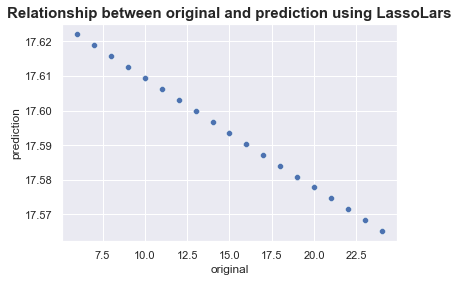

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
dataFrame = pd.DataFrame(
    {'original': original,
     'prediction': predict
    }) #create a dataframe for the data
ax = sns.scatterplot(data=dataFrame, x="original", y="prediction")
ax.set_title('Relationship between original and prediction using LassoLars',
             fontdict= { 'fontsize': 15, 'fontweight':'bold'});

6. Stochastic gradient descent

In [186]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def SGDRegress(sub_sum_pos,sub_sum_neg,pheno):
    
    test_image = []
    original = []
    predict = []
    
    for i in range(np.shape(sub_sum_pos)[0]):
        print("On subject %s" %i)
        loo_sub_sum_pos = np.delete(sub_sum_pos,[i])
        single_sub_sum_pos = sub_sum_pos[i]
        loo_sub_sum_neg = np.delete(sub_sum_neg,[i])
        single_sub_sum_neg = sub_sum_neg[i]
        loo_pheno = np.delete(pheno,[i])
        single_sub_pheno = pheno[i]
        X_train = np.vstack((np.reshape(loo_sub_sum_pos,(1,315)), np.reshape(loo_sub_sum_neg,(1,315))))
        X_train = np.transpose(X_train)
        Y_train = loo_pheno
        reg = make_pipeline(StandardScaler(), SGDRegressor(alpha=1.0)).fit(X_train, Y_train)
        '''
        Args
        
        1. loss
        The ‘squared_loss’ refers to the ordinary least squares fit. 
        ‘huber’ modifies ‘squared_loss’ to focus less on getting outliers correct by switching from 
        squared to linear loss past a distance of epsilon. ‘epsilon_insensitive’ ignores errors less 
        than epsilon and is linear past that; this is the loss function used in SVR. 
        ‘squared_epsilon_insensitive’ is the same but becomes squared loss past a tolerance of epsilon.
        
        2. penalty
        The penalty (aka regularization term) to be used. Defaults to ‘l2’ which is the standard regularizer 
        for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not 
        achievable with ‘l2’.
        
        3. alphafloat, default=0.0001
        Constant that multiplies the regularization term. The higher the value, the stronger the regularization. 
        Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.
        
        
        '''
        test_x = np.transpose(np.vstack((single_sub_sum_pos,single_sub_sum_neg)))
        prediction = reg.predict(test_x)
        test_image.append(test_x)
        original.append(single_sub_pheno)
        predict.append(prediction[0])
    
    return original,predict,test_image

In [187]:
original, predict, test_image = SGDRegress(sub_sum_pos,sub_sum_neg,pheno)
cor = np.corrcoef(np.asarray(original),np.asarray(predict))[0][1]
print("Correlation of the predicted and original score is %s." %cor)

On subject 0
On subject 1
On subject 2
On subject 3
On subject 4
On subject 5
On subject 6
On subject 7
On subject 8
On subject 9
On subject 10
On subject 11
On subject 12
On subject 13
On subject 14
On subject 15
On subject 16
On subject 17
On subject 18
On subject 19
On subject 20
On subject 21
On subject 22
On subject 23
On subject 24
On subject 25
On subject 26
On subject 27
On subject 28
On subject 29
On subject 30
On subject 31
On subject 32
On subject 33
On subject 34
On subject 35
On subject 36
On subject 37
On subject 38
On subject 39
On subject 40
On subject 41
On subject 42
On subject 43
On subject 44
On subject 45
On subject 46
On subject 47
On subject 48
On subject 49
On subject 50
On subject 51
On subject 52
On subject 53
On subject 54
On subject 55
On subject 56
On subject 57
On subject 58
On subject 59
On subject 60
On subject 61
On subject 62
On subject 63
On subject 64
On subject 65
On subject 66
On subject 67
On subject 68
On subject 69
On subject 70
On subject 71
On

**Use correlation to evaluate different models with different alpha values (the value that control the regularization/penalty)**

*Correlation of each model with different alpha*

|  | LSR | Ridge | Lasso | ElasticNet | LARS-Lasso | Stochastic gradient descent | 
| --- | --- | --- | --- | --- | --- | --- |
| alpha = 0.0 | 0.5894942746983071 |0.5894942746983067 | 0.5894942746983067 | 0.5894942746983067 | 0.5894942746983068 | 0.5894944595848238 |
| alpha = 0.1 | / | 0.5894942657346615 | 0.5894519058277794 | 0.5894719470529471 | 0.5169165935569177 | 0.5891520624645177 | 
| alpha = 0.2 | / | 0.5894942567660058 | 0.5894032548024233 | 0.5894471287093305 | -1.0 | 0.5895695339551591 |
| alpha = 0.3 | / | 0.5894942477923397 | 0.589348130112169 | 0.5894197471228471 | -1.0 | 0.5887090551304505 |
| alpha = 0.4 | / | 0.589494238813663 | 0.5892863911737424 | 0.5893897830994119 | -1.0 | 0.5884137119056182 |
| alpha = 0.5 | / | 0.5894942298299759 | 0.5892178948780954 | 0.5893572173765593 | -1.0 | 0.5881458294354422 |
| alpha = 0.6 | / | 0.5894942208412788 | 0.5891424955577386 | 0.5893220306242982 | -1.0 | 0.5874995443343022 |
| alpha = 0.7 | / | 0.5894942118475708 | 0.5890600449542791 | 0.5892842034459883 | -1.0 | 0.5882114874616413 |
| alpha = 0.8 | / | 0.5894942028488538 | 0.5889703921861977 | 0.5892437163792422 | -1.0 | 0.5873394456538039 |
| alpha = 0.9 | / | 0.5894941938451262 | 0.5888733837169156 | 0.5892005498968458 | -1.0 | 0.5876962520402159 |
| alpha = 1.0 | / | 0.589494184836389 | 0.588768863323186 | 0.5891546844077098 | -1.0 | 0.5865179031388511 |

Question: 

1. what if the summary statics use entropy rather than simple summary?

2. What if the original coding scheme is changed to sparse encoding? 

**Using entropy as summary statistics**

The following steps are divided into

1) calculate the entropy stats as the summary stats

2) call the main function to calculate the steps up to the summary stats 

3) Use least sqaure multiple regression to do the prediction

4) Use correlation to evaluate whether the model is a good fit. 


In [279]:
from pyitlib import discrete_random_variable as drv

In [382]:
def entropy_stats(all_pos,all_neg):
    pos_sum = []
    neg_sum = []
    size = 268
    for pos_mat in all_pos:
        reshaped_pos = np.reshape(pos_mat, (268 * 268, 1))
        droped_pos = reshaped_pos[reshaped_pos!=0.]
        droped_pos = droped_pos[droped_pos!=-0.] #it doesn't matter whether it's zscored or not. 
        pos = ant.sample_entropy(droped_pos)
        '''
        Entropy candidate to consider: app_entropy, perm_entropy, sample_entropy
        '''
        pos_sum.append(pos)
        
    for neg_mat in all_neg:
        reshaped_neg = np.reshape(neg_mat, (268 * 268, 1))
        droped_neg = reshaped_neg[reshaped_neg!=0.]
        droped_neg = droped_neg[droped_neg!=-0.]
        neg = ant.sample_entropy(droped_neg)
        neg_sum.append(neg)
        
    return pos_sum, neg_sum

In [383]:
def entropy_main():
    size = (268,268) #set up the size of each matrix for each subject
    filepath = '/Users/yutingzhang/Downloads/conmat_HCP_run_316_201216.mat'
    print('finished with filepath')
    array = read_file(filepath) #read in the file
    pheno, sub_mat = extract_data(array) #extract the matrix and phenotype data
    print('finished with a')
    cor_mat, p_mat = matrix_gen(pheno,sub_mat) #extract the correlation matrix and p-value matrix for all subjects
    pos_mat, neg_mat = edge_selection(cor_mat,p_mat,size) #edge selection with two matrices, one for pos, one for neg
    print('finished with b')
    sub_pos, sub_neg = element_multiply(sub_mat,pos_mat,neg_mat) #using the matrix to apply to the actual subject data to select that
    sub_sum_pos,sub_sum_neg = entropy_stats(sub_pos,sub_neg) #calculate the summary statistics
    print('finished with c')
    return sub_sum_pos,sub_sum_neg,pheno

In [384]:
sub_sum_pos,sub_sum_neg,pheno = entropy_main()

finished with filepath


<ipython-input-2-d8281cbeaf95>:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(filepath)


finished with a


/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


finished with b
finished with c


In [385]:
from sklearn.linear_model import LinearRegression
def OLS(sub_sum_pos,sub_sum_neg,pheno):
    original = []
    predict = []
    
    for i in range(np.shape(sub_sum_pos)[0]):
        print("On subject %s" %i)
        loo_sub_sum_pos = np.delete(sub_sum_pos,[i])
        single_sub_sum_pos = sub_sum_pos[i]
        loo_sub_sum_neg = np.delete(sub_sum_neg,[i])
        single_sub_sum_neg = sub_sum_neg[i]
        loo_pheno = np.delete(pheno,[i])
        single_sub_pheno = pheno[i]
        X_train = np.vstack((np.reshape(loo_sub_sum_pos,(1,315)), np.reshape(loo_sub_sum_neg,(1,315))))
        X_train = np.transpose(X_train)
        Y_train = loo_pheno
        reg = LinearRegression().fit(X_train, Y_train)
        prediction = reg.predict(np.transpose(np.vstack((single_sub_sum_pos,single_sub_sum_neg))))
        original.append(single_sub_pheno)
        predict.append(prediction[0])
    return original,predict

In [386]:
original, predict = OLS(sub_sum_pos,sub_sum_neg,pheno)
cor = np.corrcoef(np.asarray(original),np.asarray(predict))[0][1]
print("Correlation of the predicted and original score is %s." %cor)

On subject 0
On subject 1
On subject 2
On subject 3
On subject 4
On subject 5
On subject 6
On subject 7
On subject 8
On subject 9
On subject 10
On subject 11
On subject 12
On subject 13
On subject 14
On subject 15
On subject 16
On subject 17
On subject 18
On subject 19
On subject 20
On subject 21
On subject 22
On subject 23
On subject 24
On subject 25
On subject 26
On subject 27
On subject 28
On subject 29
On subject 30
On subject 31
On subject 32
On subject 33
On subject 34
On subject 35
On subject 36
On subject 37
On subject 38
On subject 39
On subject 40
On subject 41
On subject 42
On subject 43
On subject 44
On subject 45
On subject 46
On subject 47
On subject 48
On subject 49
On subject 50
On subject 51
On subject 52
On subject 53
On subject 54
On subject 55
On subject 56
On subject 57
On subject 58
On subject 59
On subject 60
On subject 61
On subject 62
On subject 63
On subject 64
On subject 65
On subject 66
On subject 67
On subject 68
On subject 69
On subject 70
On subject 71
On

*Correlation of least sqaure model with different entropy as the summary stats*

|  | app_entropy | perm_entropy | sample_entropy | 
| --- | --- | --- | --- | 
| cor | 0.01641536189675583 | 0.030878640150066024 | -0.06188538442233747 |


*Ignore the following*

In [53]:
#apply logistic regression
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train,Y_train)
logisticRegr.predict(X_test[0:100])

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([21., 20., 21., 21., 23., 19., 21., 20., 21., 21., 20., 21., 21.,
       20., 23., 22., 21., 21., 20., 20., 20., 21., 21., 20., 20., 20.,
       21., 21., 21., 21., 21., 22., 20., 21., 11., 21., 20., 11., 11.,
       20., 21., 21., 21., 20., 11., 15., 20., 21., 21., 11., 21., 22.,
       21., 21., 20., 21., 20., 23., 21., 20., 21., 20., 21., 20., 21.,
       21., 21., 21., 21., 21., 15., 21., 21., 21., 22., 23., 20., 21.,
       22., 20., 21., 21., 21., 11., 16., 20., 23., 21., 22., 20., 22.,
       21., 21., 11., 23., 20., 20., 21., 21., 23.])

In [54]:
#test the results for logistic regression
logisticRegr.score(X_test,Y_test)

0.1619047619047619

In [ ]:
#apply linear model, ordinary least squares


In [ ]:
#apply 

In [ ]:
#fit the data using pca_com
pca_com.fit(X_train)


In [9]:
pca = PCA(n_components = 2)
Principle_Component = pca.fit_transform(mat_rest)

In [11]:
dataframe = pd.DataFrame(data = Principle_Component, columns = ['Principal Component 1','Principal Component 2'])

In [12]:
dataframe

,Principal Component 1,Principal Component 2
0,-2.388122,2.989775
1,3.251931,0.620193
2,-4.806732,4.823993
3,-3.364801,3.938786
4,0.363586,-1.682348
...,...,...
311,-0.650153,2.143270
312,-1.102755,2.037828
313,-0.426162,2.153671
314,0.691928,5.480188


In [18]:
from sklearn.model_selection import train_test_split

In [35]:
#save pickle file

mat_rest = arrays['mat_rest']
pickle_out = open("/Users/yutingzhang/Downloads/attention_array.pickle","wb")
pickle.dump(mat_rest, pickle_out)
pickle_out.close()

sub_list = arrays['subList']
pickle_out = open("/Users/yutingzhang/Downloads/attention_sublist.pickle","wb")
pickle.dump(sub_list, pickle_out)
pickle_out.close()



In [30]:
#load in pickle file as a list
pickle_file = open('/Users/yutingzhang/Downloads/attention_array.pickle','rb')
objects = []
while True:
    try:
        objects.append(pickle.load(pickle_file))
    except EOFError:
        break
pickle_file.close()


In [43]:
pointer = arrays['id_name'][0][0]
arrays['id_name'][pointer]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices